# MHNreact
[![arXiv](https://img.shields.io/badge/arXiv-2104.03279-b31b1b.svg)](https://arxiv.org/abs/2104.03279)
[![Python 3.7](https://img.shields.io/badge/python-3.7-blue.svg)](https://www.python.org/downloads/release/python-370/)
[![Python 3.8](https://img.shields.io/badge/python-3.8-blue.svg)](https://www.python.org/downloads/release/python-380/)
[![Pytorch](https://img.shields.io/badge/Pytorch-1.6-red.svg)](https://pytorch.org/get-started/previous-versions/)
[![License](https://img.shields.io/badge/License-BSD%202--Clause-orange.svg)](https://opensource.org/licenses/BSD-2-Clause)

Adapting modern Hopfield networks [(Ramsauer et al., 2021)](#mhn) (MHN) to associate different data modalities, molecules and reaction templates, to improve predictive performance for rare templates and single-step retrosynthesis.
Code based on the git-repo: https://github.com/ml-jku/mhn-react


# Preliminaries / Requirements ⚙️ (run once)
preferably with the setting -- Runtime -- Change runtime type -- GPU ;)

after running the command it's save to restart the environement

In [1]:
%%capture
!pip install rdkit-pypi
!pip install torch scipy ipykernel matplotlib sklearn swifter wandb rdchiral
!git clone https://github.com/ml-jku/mhn-react
!mv mhn-react/* .
# for prepro and running reactions (not strictly necessary)
!pip install -e "git://github.com/connorcoley/rdchiral.git#egg=rdchiral"
!pip install -e data/temprel-fortunato/template-relevance-master/

# Training 🔥 

Models can be trained using ````python mhnreact/train.py -m````

Selected calls are documented within ````./notebooks/*_training_*.ipynb````.

single-step-retrosynthesis evaluation with ```--ssretroeval True```, with only one CPU will take around 2 hours in colab.

Here's an example for a single-step-retrosynthesis model training:

In [2]:
!python -m mhnreact.train --model_type=mhn --fp_size=10000 --fp_type maccs+morganc+topologicaltorsion+erg+atompair+pattern+rdkc+layered+mhfp --template_fp_type maccs+morganc+topologicaltorsion+erg+atompair+pattern+rdkc+layered+mhfp --concat_rand_template_thresh 1 \
--exp_name test --dataset_type 50k --csv_path ./data/USPTO_50k_MHN_prepro.csv.gz --ssretroeval False --seed 0 --save_model True

seeded with 0
loading X, y from csv
valid 5001 samples
train 40008 samples
test 5007 samples
11800 templates
100% 5001/5001 [00:55<00:00, 89.46it/s] 
100% 40008/40008 [07:20<00:00, 90.83it/s] 
tcmalloc: large alloc 3200647168 bytes == 0x55912327a000 @  0x7f4aceeff1e7 0x7f4acc83f46e 0x7f4acc88fc7b 0x7f4acc892e83 0x7f4acc89307b 0x7f4acc934761 0x55903f73c4b0 0x55903f73c240 0x55903f7b00f3 0x55903f7aaced 0x55903f73dbda 0x55903f7ac737 0x55903f7aaced 0x55903f67ce2b 0x55903f7acfe4 0x55903f7aa9ee 0x55903f73e48c 0x55903f73e698 0x55903f7acfe4 0x55903f7aa9ee 0x55903f73dbda 0x55903f7abc0d 0x55903f7aa9ee 0x55903f73e48c 0x55903f781409 0x55903f73cd49 0x55903f7b094f 0x55903f7aa9ee 0x55903f7aa6f3 0x55903f7a8b60 0x55903f73c349
100% 5007/5007 [00:54<00:00, 91.98it/s] 
/content/mhnreact/train.py:465: UserWarning: Persisting input arguments took 0.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some l

# View model outputs

Let's load in the trained model and run inference

In [3]:
from mhnreact.inspect import list_models, load_clf, smarts2svg
model_fn = list_models()[0]
clf = load_clf(model_fn)

{'fingerprint_type': 'maccs+morganc+topologicaltorsion+erg+atompair+pattern+rdkc+layered+mhfp', 'template_fp_type': 'maccs+morganc+topologicaltorsion+erg+atompair+pattern+rdkc+layered+mhfp', 'num_templates': 11800, 'fp_size': 10000, 'fp_radius': 2, 'device': 'cpu', 'batch_size': 128, 'pooling_operation_state_embedding': 'mean', 'pooling_operation_head': 'max', 'dropout': 0.2, 'lr': 0.0005, 'optimizer': 'Adam', 'activation_function': 'ReLU', 'verbose': False, 'hopf_input_size': 10000, 'hopf_output_size': None, 'hopf_num_heads': 1, 'hopf_asso_dim': 512, 'hopf_association_activation': 'None', 'hopf_beta': 0.05, 'norm_input': True, 'norm_asso': True, 'hopf_n_layers': 0, 'mol_encoder_layers': 1, 'temp_encoder_layers': 1, 'encoder_af': 'ReLU', 'hopf_pooling_operation_head': 'mean'}
loading templates+noise


In [4]:
# load in the dataset
from mhnreact.data import load_dataset_from_csv
X,y,t,test_reactants_can = load_dataset_from_csv('data/USPTO_50k_MHN_prepro.csv.gz', ssretroeval=True)

loading X, y from csv
test 5007 samples
valid 5001 samples
train 40008 samples
11800 templates
obfuscating 706 templates because they are only in test


In [5]:
# inference
clrs = clf.softmax(clf.forward_smiles(X['test'])).detach().cpu().numpy()

In [6]:
preds = clrs.argsort(1)[:,::-1]

The input sample nr 52: COC(=O)c1ccc2ccn(-c3ccc(C)cc3)c2c1


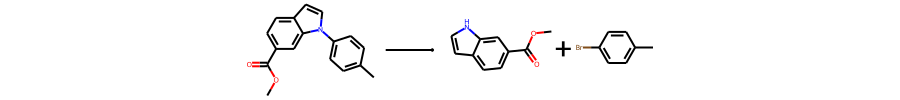

acutal: 2739, pos_pred: 3 with prob: 0.0033289594; [NH2;D1;+0:1]-[c:2]>>O=[N+;H0;D3:1](-[O-])-[c:2]


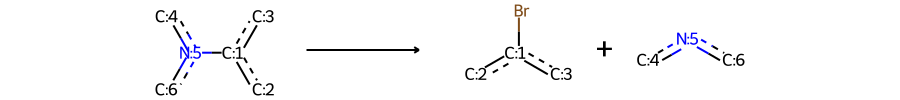




predicted top-1 - index: 1465, prob: 42.1%; [c:4]:[n;H0;D3;+0:5](:[c:6])-[c;H0;D3;+0:1](:[c:2]):[c:3]>>I-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+0:5]:[c:6]


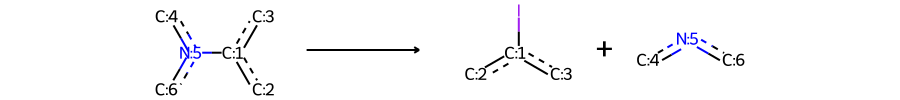

predicted top-2 - index: 1366, prob: 7.7%; [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[c:4]):[c:6]>>I-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+0:5]:[c:6]


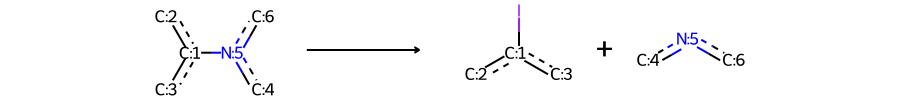

predicted top-3 - index: 2739, prob: 5.6%; [c:4]:[n;H0;D3;+0:5](:[c:6])-[c;H0;D3;+0:1](:[c:2]):[c:3]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+0:5]:[c:6]


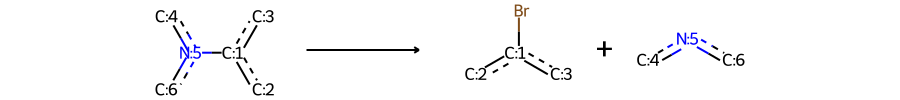

predicted top-4 - index: 3649, prob: 4.7%; [c:4]:[n;H0;D3;+0:5](:[c:6])-[c;H0;D3;+0:1](:[c:2]):[c:3]>>O-B(-O)-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+0:5]:[c:6]


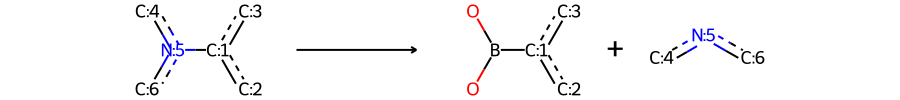

predicted top-5 - index: 2425, prob: 3.1%; [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[c:4]):[c:6]>>F-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+0:5]:[c:6]


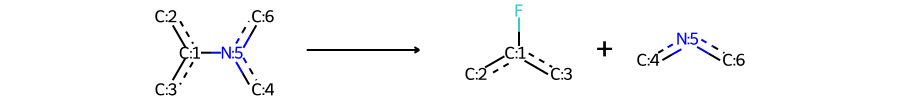

In [8]:
from scipy.special import softmax
from rdkit.Chem import rdChemReactions
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage


ii = 52 #np.random.randint(len(y['test']))

smiles = X['test'][ii][0]
y_true = y['test'][ii]

clr = clrs[ii]

pos_pred = (preds[ii]==y_true).argmax()+1

# the input sample
print(f'The input sample nr {ii}: {smiles}')
smarts2svg(smiles+'>>'+test_reactants_can[ii], highlightByReactant=True)

# the ground truth
print(f'acutal: {y_true:3.0f}, pos_pred: {pos_pred} with prob: {clr[pos_pred]*100:2.10f}; {t[pos_pred]}')
smarts2svg(t[y_true], useSmiles=False, highlightByReactant=False)
print('\n'*2)

for n, pred in enumerate(preds[ii][:5]):
    print(f'predicted top-{n+1} - index: {pred}, prob: {clr[pred]*100:2.1f}%; {t[pred]}')
    svg = smarts2svg(t[pred], useSmiles=False, highlightByReactant=False)